## Spike sorting demo for BRW files
----

https://gist.github.com/mhhennig/97453faec66ea78f96e61a193f699e6c

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import pathlib
import sys, os

import spikeinterface.full as si
import spikeinterface.preprocessing as st

%matplotlib inline

Set the file path.

In [2]:
raw_file = pathlib.Path('Y:', 'users', 'michael.zabolocki', '3Brain_spikes_OC_Grade', 'OC_Ephis data', 'CTL', '021023_IN', 'Baseline', 's1_bs.brw')

# check the file path
if not raw_file.exists():
    print(f'File {raw_file} does not exist')
    sys.exit(1)

Initalized the object.

In [13]:
RX = si.BiocamRecordingExtractor(raw_file)
RX

BiocamRecordingExtractor: 4096 channels - 13.8kHz - 1 segments - 2,066,017 samples 
                          150.00s (2.50 minutes) - uint16 dtype - 15.76 GiB
  file_path: Y:users\michael.zabolocki\3Brain_spikes_OC_Grade\OC_Ephis data\CTL\021023_IN\Baseline\s1_bs.brw

Plot the raw traces.

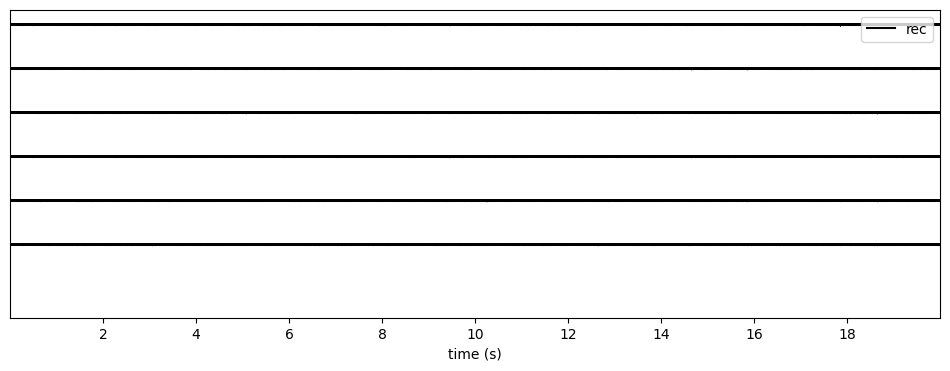

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
si.plot_traces(RX, time_range=[0,20], ax=ax, channel_ids=['10', '11', '12', '15', '16', '18'])

In [36]:
# RX_filtered = st.BlankSaturationRecording(RX, quantile_threshold=0.999)
# RX_filtered = st.normalize_by_quantile(RX_filtered, scale=20)

c:\Users\michael.zabolocki\Documents\code\3brain_gradelab\.venv\lib\site-packages\spikeinterface\preprocessing\normalize_scale.py:100: RuntimeWarning: divide by zero encountered in divide
  gain = scale / pre_scale


Bandpass filter.

In [44]:
RX_filtered_bpass = si.bandpass_filter(RX, freq_min=300, freq_max=3000)
RX_filtered_bpass

BandpassFilterRecording: 4096 channels - 13.8kHz - 1 segments - 2,066,017 samples 
                         150.00s (2.50 minutes) - int16 dtype - 15.76 GiB

Remove bad channels.

In [46]:
# # detect
# bad_channel_ids, channel_labels = st.detect_bad_channels(recording=RX_filtered_bpass)
# # Case 1 : remove then
# rec_clean = RX_filtered_bpass.remove_channels(remove_channel_ids=bad_channel_ids)

# print(f'Bad channels: {bad_channel_ids}')

Common median reference.

In [47]:
recording_cmr = st.common_reference(recording=RX_filtered_bpass, operator="median")

Normalize the recordings. Apply the gains and offsets.

In [48]:
rec_normed = st.zscore(recording=recording_cmr)

c:\Users\michael.zabolocki\Documents\code\3brain_gradelab\.venv\lib\site-packages\spikeinterface\preprocessing\normalize_scale.py:295: RuntimeWarning: divide by zero encountered in divide
  gain = 1 / mads
c:\Users\michael.zabolocki\Documents\code\3brain_gradelab\.venv\lib\site-packages\spikeinterface\preprocessing\normalize_scale.py:296: RuntimeWarning: invalid value encountered in divide
  offset = -medians / mads


Bandpass filter and re-plot the data.

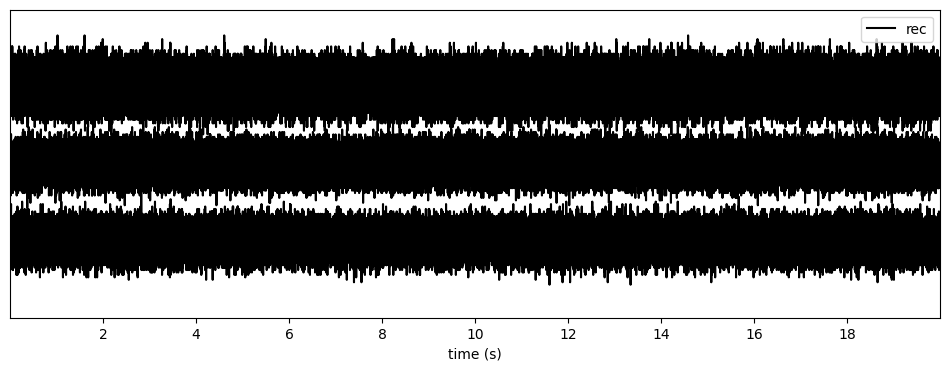

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
si.plot_traces(rec_normed, time_range=[0,20], ax=ax, channel_ids=['2825', '2826', '3415'])

In [35]:
rec_normed

BandpassFilterRecording: 4096 channels - 13.8kHz - 1 segments - 2,066,017 samples 
                         150.00s (2.50 minutes) - float32 dtype - 31.52 GiB

**to do**
- subselect for the channels overlapping with the channels